# Computer Science 109A Final Project
## Predicting Exoplanet Equilibrium Temperatures with NASA Exoplanet Data

**Authors:** Sage Crystian, Alice Liu, Josh Rosenblum, Bella Tarantino

## Table of Contents 

[Overview](#overview) 

&nbsp;&nbsp;&nbsp;&nbsp;[Project Question](#project-question)

&nbsp;&nbsp;&nbsp;&nbsp;[Data Description](#data-description)

[Data Pre-Processing and EDA](#data-pre-processing-and-eda)

&nbsp;&nbsp;&nbsp;&nbsp;[Data Cleaning and Feature Selection](#data-cleaning-and-feature-selection)

&nbsp;&nbsp;&nbsp;&nbsp;[EDA](#eda)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Data Summary](#data-summary)

&nbsp;&nbsp;&nbsp;&nbsp;[Feature Selection](#feature-selection)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Relationships Between Predictor and Response](#relationships-between-predictors-and-response)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Mass-Radius and Mass-Luminosity Empirical Relationships Used For Imputation](#mass-radius-mass-luminosity)



## Overview
<a class="anchor" id="overview"></a>

### Project Question 
<a class="anchor" id="project-question"></a>
Our project question is: 

> “Can we predict the equilibrium temperature of a planet based on the planetary and solar characteristics?”

The reason we have chosen the planetary equilibrium temperature as our response variable is due to its  relationship with habitability.  Most predictors for habitability exist outside of the scope of our dataset and require more careful and detailed analysis of the planetary characteristics.  The equilirbium temperature of an exoplanet helps determine whether liquid water, an essential condition to life as we know it, can exist, making it an important screening for habitability.

### Data Description 
<a class="anchor" id="data-description"></a>
The data we are using is the [“Confirmed Planets”](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1&constraint=disc_facility+like+%27%25TESS%25%27) dataset from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html), which contains information about detected and confirmed exoplanets. To identify these exoplanets, NASA creates a catalog of thousands of candidates using countless detection methods and conducts follow-up ground-based observations to confirm that the candidates are true exoplanets and not false positives. 

After cleaning the data and removing duplicates, we are left with 5535 observations, 1060 of which have our response variable, `pl_eqt`, present. 

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import xgboost as xgb

import helpers 

# pandas tricks for better display
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Hide warnings for convenience
from warnings import simplefilter
from pandas.errors import SettingWithCopyWarning
    
simplefilter('ignore', category=FutureWarning)
simplefilter('ignore', category=UserWarning)
simplefilter('ignore', category=SettingWithCopyWarning)

# Have plots display as SVG and set default figure size
%config InlineBackend.figure_formats = ['svg']
plt.rcParams["figure.figsize"] = (10, 6)

## Data Pre-Processing and EDA
<a class="anchor" id="data-pre-processing-and-eda"></a>

### Data Cleaning and Feature Selection 
<a class="anchor" id="data-cleaning-and-feature-selection"></a>

We begin with cleaning the data by removing empty columns, empty rows, duplicate rows, and rows which are missing our predictor, `pl_eqt`.  For duplicate rows (rows which contain data about planets whose properties have already been obsered), we chose to keep the *most recent* entry for a given observation. 

After this, we separated our data into predictors and response. The selection for predictors was motivated in previous milestones but will be briefly motivated again in the following section.

In [2]:
# Import data as df
df = pd.read_csv('./tess_exoplanet_data.csv', low_memory=False)

# Remove duplicates, empty columns, and empty rows 
df = df.dropna(axis=0, how='all')
df = df.dropna(axis=1, how='all')
df = df.sort_values(by='rowupdate', ascending=False).drop_duplicates(subset='pl_name', keep='first')

# Remove rows without response variable 
df = df.dropna(subset=['pl_eqt'])

# Select X and y data 
predictors = ['st_teff', 'st_rad', 'st_mass', 'st_lum', 'pl_orbper']
X, y = df[predictors], df['pl_eqt']

### EDA 
<a class="anchor" id="eda"></a>
In this section, we perform a preliminary examination of the dataset. 

First, we examine the shape of the data.  Further exploration of missingness will happen in the imputation section below. With duplicates, empty columns, empty rows, and rows with missing a missing response variable, we see that the data has 1085 rows and 285 columns. This data is updated daily, so, should you choose to download the data from the NASA Exoplanet Archive directly, these figures may not be consistent with our description of the data.  Our data was accessed on December 15, 2023 at 10:00AM ET and the figures in this notebook reflect the data at this time. 

In [3]:
# Identify the shape of the data
df.shape

(1085, 285)

Next, we examine the properties of the columns; we can observe the different unique datatypes present in the columns and the count of each datatype. From the results, we see most columns are numerical values, primarily integers. 

In [4]:
# Identify the unique data types present in the features
print(f'Unique datatypes: {df.dtypes.unique().tolist()}')

# Identify the counts of each datatype present in the features
print(f'Counts of each datatype: {df.dtypes.value_counts().tolist()}')

Unique datatypes: [dtype('int64'), dtype('O'), dtype('float64')]
Counts of each datatype: [233, 27, 25]


As we have already performed feature selection, as outlined below, we can now examine the relationships between our predictors.  We see that the distributions for stellar radius (`st_rad`), stellar mass (`st_mass`), planet orbital period (`pl_orbper`), and planet equilibrium temperature (`pl_eqt`) are all somewhat left-skewed.  This is an expected result, as astonomical observations will generally happen for larger bodies.  We also expect the right-skewed stellar temperature (`st_lum`), as hotter suns may be brighter and thus easier to detect. 

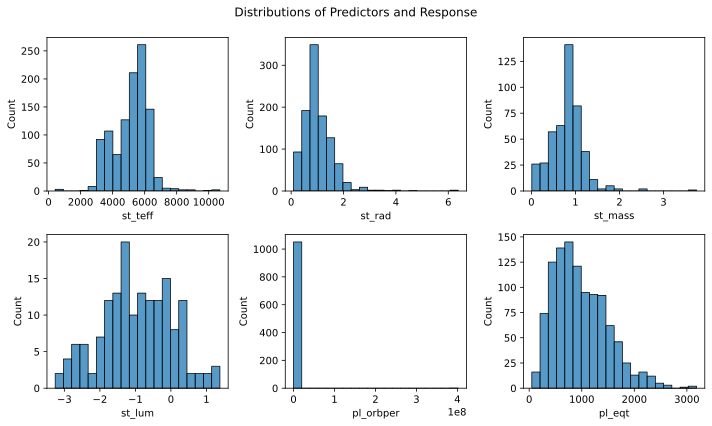

In [5]:
# Create histogram of predictors
for i in range(len(X.columns)):
  plt.subplot(2, 3, i+1)
  sns.histplot(data=X, x=X[X.columns[i]], bins=20)

# Add histogram for the response variable 
plt.subplot(2, 3, 6)
sns.histplot(data=y, x=y, bins=20)

plt.suptitle("Distributions of Predictors and Response")
plt.tight_layout(rect=[0, 0, 1, 0.99])

Next, we can quickly inspect relationships between the predictors and the response variable. The plots below indicate the presence of a few outliers, which may impact our predictions; specifically, three planets have an orbital period that is multiple magnitudes larger than the rest, thus we remove them below.

We also confirm that there are strong visual relationships between our predictors and the response variable.

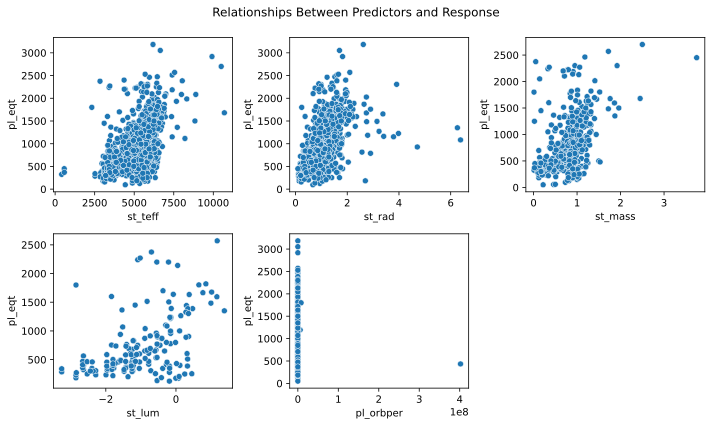

In [6]:
# Plot each predictor against the response variable 
for i in range(len(X.columns)):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=X[X.columns[i]], y=y)

# Label plots 
plt.suptitle("Relationships Between Predictors and Response")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [7]:
# Drop the 3 outliers in the orbital period 
X = X.drop(index=X.nlargest(3, 'pl_orbper').index)
y = y.loc[X.index]

In our exploration of the data, we should also visualize missingness and the correlation between predictors. These visualizations happen in the Feature Selection and Imputation sections, respectively. Thus, this concludes our EDA.

### Feature Selection
<a class="anchor" id="feature-selection"></a>

As stated in Milestone 4, we used the below equations to select physically relevant predictors and to impute missing data. The calculation of the distance, a predictor, along with the imputation of stellar effective temperature and stellar mass, come from the equations below. 

#### Relationships Between Predictors and Response 
<a class="anchor" id="relationships-between-predictors-and-response"></a>

**Please note that effective temperature and equilibrium temperature refer to the same physical quantity.**

How warm a planet gets significantly depends on the luminosity of the star. Solar luminosity is defined by the following equation:

$$
1)\ \ 
L_{\odot} = 4\pi R_{\odot}^2\sigma T^4 
$$

where $ R_{\odot}$ is the stellar radius, $\sigma$ is Steffan-Boltzmann constant, and $T$ is the stellar surface temperature.

**From equation 1), we will be including $L_{\odot}$, $R_{\odot}$, and $T$ in our feature selection. This equation is also used in the imputation of $L_{\odot}$, given that both $R_{\odot}$, and $T$ are present for a given row.**

The amount of power per unit area a planent receieves from a star is the **insolation flux**:
$$
2)\ \ 
F= \frac{\ L_{\odot}}{4\pi d^2}
$$

The equation below represents how Equilibrium Temperature is calculated for planets. It's derivation is shown in the previous milestone.

$$
3)\ \ 
T_{eff} =  \sqrt[4]{\frac{L_{\odot} (1 - A)}{16\pi \sigma d^2}}
$$

Note that 
$$
3.1)\ \ 
T_{eff} =  \sqrt[4]{\frac{L_{\odot} (1 - A)}{16\pi \sigma d^2}} = \sqrt[4]{\frac{\ F (1 - A)}{4 \sigma}}
$$
meaning that Effective Temperature is directly dependent on insolation flux.



The equation below represents Kepler's 3rd law relating a planet's distance from its star with period and the mass of the star and the planet. 
$$
4)\ \ 
d = \sqrt[3]{\frac{G P^2  M}{4\pi^2}}
$$

where $M$ is the mass of the star, $P$ is the period of orbit around a star, and *G* is the gravitational constant. This equation is also used in the calculation of the distance predictor in the previous Milestone 4.

Based on equation 4), additional important variables for feature selection are $M$ and $P$. These equations allow us to select physically significant variables: $M, L_{\odot}$, $R$, $T$, $P$, $d$, and $F$.

**However, it is difficult to measure many characteristics of a star and its planets completely and accurately, as seen in the data below. If we have all these predictors, we could simply determine if a planet can be potentially habitable or not based on the planet's equilibrium temperature. The steps taken below wouldn't be necessary. Thus, it is much more scientifically and analytically impactful to determine if we can predict planet equilibrium tempearture without all predictors that would defintively inform us so.** 
**As a result, we will determine if we can predict planet equilibrium temperature using only the following predictors: `st_lum`, `st_rad`, `st_mass`, `st_teff`, and `pl_orbper`** or **$M, L_{\odot}$, $R$, $T$, $P$**

### Mass-Radius and Mass-Luminosity Empirical Relationships Used For Imputation
<a class="anchor" id="mass-radius-mass-luminosity"></a>

Below are equations based on fitting emperical data for radius R versus mass M for stars whose mass is known. Most stars lies along a relatively well defined mass-radius relation. These stars are called "main-sequence" stars and are defined well by these pair of power law equations:

$$
5.1)\ \ 
\frac{R}{R_\odot} = 1.06(\frac{M}{M_\odot})^{0.945}  \ \ \  \ M< 1.66{M_\odot}
$$

$$
5.2)\ \  
\frac{R}{R_\odot} = 1.33(\frac{M}{M_\odot})^{0.555}  \ \ \  \ M> 1.66{M_\odot}
$$

These can be rewritten as:

$$
5.3)\ \ 
\frac{M}{M_\odot} = 0.940(\frac{R}{R_\odot})^{1.06}  \ \ \  \ R< 1.74{R_\odot}
$$

$$
5.4)\ \  
\frac{M}{M_\odot} = 0.598(\frac{R}{R_\odot})^{1.80}  \ \ \  \ R> 1.74{R_\odot}
$$

**Equations 5.3) and 5.4) will be used to impute stellar mass, given that we have stellar radius.**

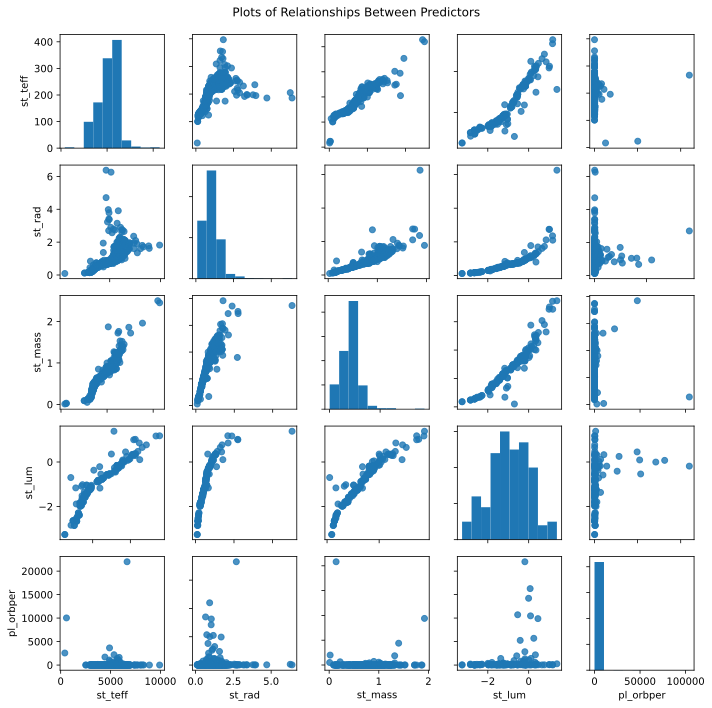

In [8]:
# Use a custom pairplot method to plot each of the predictors against each other 
helpers.pairplot(X)

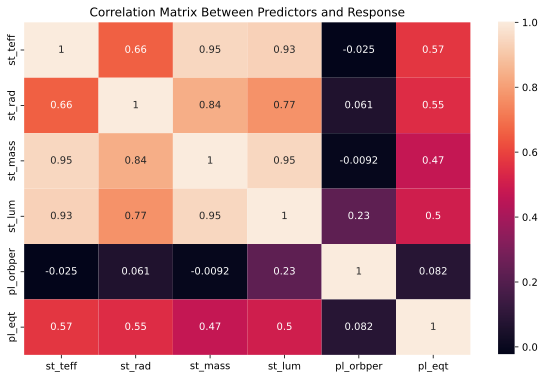

In [9]:
# Plot correlation between predictors and response 
correlation_matrix = pd.concat([X, y], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True).set(title="Correlation Matrix Between Predictors and Response");

#### Reflection of Collinearity Between Predictors <a class="anchor" id="mass-rel"></a>

As seen in the correlation matrix and the plots between different predictors above, there are noticable positive trends between different predictors, indicating collinearity. Much of these correlations are to be expected given the equations above and their strong relationships. 

For example, Equation 1) expects that we should see correlation between `st_rad` and `st_lum` (correlation of 0.77) since stellar radius directly affects stellar luminosity. The same relationship can be stated for `st_teff` and `st_lum` (correlation of 0.93)

$$
1)\ \ 
L_{\odot} = 4\pi R_{\odot}^2\sigma T^4 
$$

##### Collinearity Between Stellar Predictors
Collinearity between stellar mass, stellar radius, and stellar luminosity has been previously discussed in Milestone 4 and briefly here with equations 5.3) and 5.4). Below are 2 more equations that illustrate the relationship with stellar luminosity.

$$
5.5)\ \ 
\frac{L}{L_\odot} = 0.35(\frac{M}{M_\odot})^{2.62}  \ \ \  \ M< 0.7{M_\odot}
$$

$$
5.6)\ \ 
\frac{L}{L_\odot} = 1.02(\frac{M}{M_\odot})^{3.92}  \ \ \  \ M> 0.7{M_\odot}
$$

As seen with Equations 5.3) to 5.6), identifiable relationships between stellar luminosity, stellar radius, and stellar mass can be formed. Since stellar luminosity is dependent on stellar effective temperature, relationships can also be formed between stellar effective temperature and stellar radius/mass.

##### Collinearity Between Stellar and Planetary Predictors
The stellar predictors are weakly correlated with the planetary predictor `pl_orbsper`, $P$,  which is unexpected because Equation 4)

$$
4)\ \ 
d = \sqrt[3]{\frac{G P^2  M}{4\pi^2}}
$$

This can be rewritten as
$$
P= \sqrt[2]{\frac{4\pi^2d^3}{G M}}
$$

where $M$ is the mass of the star, $P$ is the period of orbit around a star, and *G* is the gravitational constant, $d$ is distance between. 

Orbital period is dependent on mass of the star, so it is suprising to see it weakly correlated with stellar mass. It could be that it's weakly correlated compared to distance or that the use of of the graviational constant *G* has a profound effect on the corrrelation. It is also possible that our specific correlation matrix used does not adequately offer commentary on all types of possible correlations. A final possibility is that the interaction between the terms somehow influences the correlation analysis.

### Imputation
This section follows and outlines the imputation process.  

First, we wish to motivate imputation by viewing missingness in the relevant predictors. We see that, only using rows in which all predictors and the response are present, our data is cut down to only a few hundred observations for both testing and training.  Looking at the amount of missingness present as described in the plot below, the known (re: equations above) relationship between the predictors, and exploration in prior milestones, it is safe to assume that this missingness is not completely at random.  To prevent issues with imputation due to the non-MCAR missingness, and to improve our model as much as possible, we chose to impute predictors using the equations outlined in the previous section rather than use a method such as mean, kNN, or regression imputation.  

1. Impute stellar luminosity using Equation 1
2. Impute stellar mass using Equations 5.3 and 5.4
3. Impute stellar radius using Equations 5.1 and 5.2 

But first, we wish to explore the missingness present. The data shows us that the stellar luminosity and stellar mass have the most missingness, so our immediate priority is to imputing these two to increase the amount of data we have. 

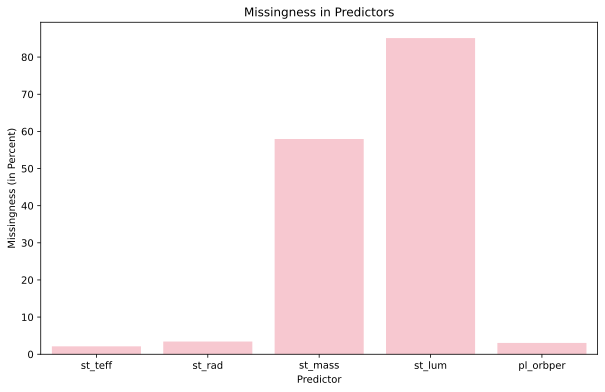

In [10]:
# Calculate missingness for each predictor and plot 
missingness_info = pd.DataFrame({
    'predictor': X.columns,
    'Before Imputation': X.isna().mean() * 100  
})

# Plot missingness
sns.barplot(data=missingness_info, x='predictor', y='Before Imputation', color='pink').set(title="Missingness in Predictors", xlabel="Predictor", ylabel="Missingness (in Percent)");

Next, we want to see if the missingness of any predictor has a relationship with the other predictors and response. From our knowledge of physics and the equations above, we can assume that there will be a relationship between the missingness of predictors and response. From the plot below, we see that there are stronger relationships between the missingness of the stellar mass and luminosity; the orbital period and the stellar radius; and the orbital period and the stellar effective temperature. We can safely conclude that we do not have Missingness Completely At Random, at least, from these explorations.

In [11]:
# Create columns for the missingness in each predictor
temp_df = X.copy() 

# Create indicator variables for the missingness of each predictors 
for column in temp_df.columns:
    missing_column = column + '_Missing'
    temp_df[missing_column] = temp_df[column].isnull().astype(int)

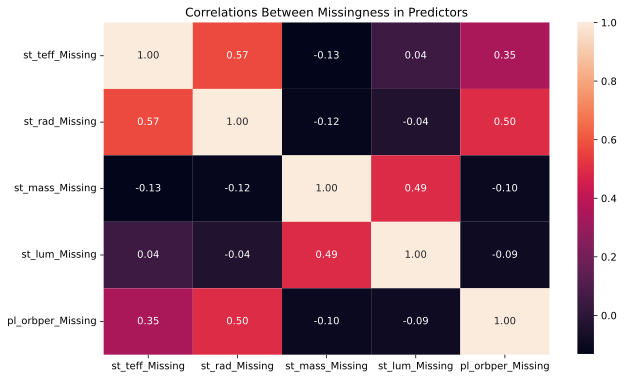

In [12]:
# Select relevant predictors and plot correlation between missingness indicator variables 
sns.heatmap(temp_df[[predictor + "_Missing" for predictor in predictors]].corr(), annot=True, fmt='.2f').set(title="Correlations Between Missingness in Predictors");

Thus, using the equations from the feature selection section above, we imputed missing values in the relevant predictors. The details of the imputation are included in the `helpers.py` file associated with this notebook.  In the process of imputation, we began by defining constants necessary for conversion and imputation; the units which the NASA Exoplanet Data uses are not consistent with the equations above, making conversion a necessary portion of our impuation process.  These constants are present in the `helpers.py` file and are indicated as such.

From the equations and methods above, it is easy to see that the imputation process will be somewhat cyclical; we may have situations in which the stellar radius and luminosity are missing, for example, but not the stellar mass or stellar temperature.  Using the stellar mass, we can calculate the stellar radius, then we can calculate the stellar luminosity using the stellar radius and stellar temperature.  Only one pass of imputation would enforce an ordered imputation, meaning not all rows would be imputed to the utmost.  As a result, we repeat the imputation process until the total missingness no longer changes; this is when the data is imputed to the best of our ability.

In [13]:
# Initialize a "difference in missingness" variable that measures the difference in missingness before and after one pass of imputation 
difference_in_missingness = np.inf

# Continue imputing until the imputation no longer improves missingness 
while difference_in_missingness != 0: 
    
    # Calcuate the total missingness before imputation
    missingness = X.isna().sum().sum()
    
    # Impute luminosity, mass, and radius 
    X['st_lum'] = X.apply(helpers.impute_st_lum, axis=1)
    X['st_mass'] = X.apply(helpers.impute_st_mass, axis=1)
    X['st_rad'] = X.apply(helpers.impute_st_rad, axis=1)

    # Calculate the change in missingness due to the imputation 
    difference_in_missingness = missingness - X.isna().sum().sum()

Finally, we can confirm that our imputation has improved the overall missingness by checking it once again.

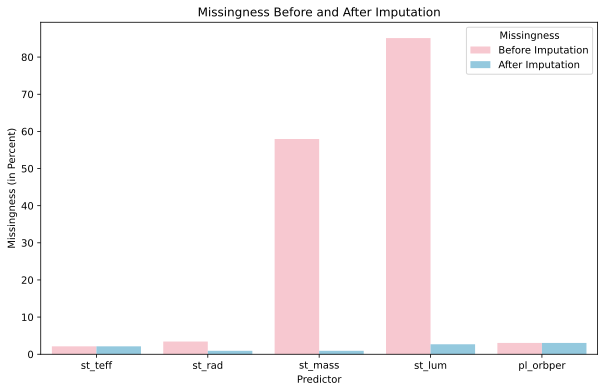

In [14]:
# Calculate missingness for each predictor after imputation  
missingness_info['After Imputation'] = X.isna().sum()/X.shape[0] * 100

# Plot the missingness before and after imputation side-by-side 
sns.barplot(x='predictor', y='value', hue='Missingness', data=pd.melt(missingness_info, id_vars='predictor', var_name='Missingness'), palette=['pink', 'skyblue']).set(title="Missingness Before and After Imputation", xlabel="Predictor", ylabel="Missingness (in Percent)");

Then, we'll drop any remaining rows with missingness, which we cannot impute due to far too many predictors being missing.

In [15]:
X = X.dropna(how='any')
y = y.loc[X.index]

### Train-Test Split 
Finally, we perform a simple train-test split with our imputed data.  In previous milestones, we showed that the imputation process improved performance both on the training set and on unknown data, thus we will continue to use the imputed data for our final training.

In [16]:
# Perform train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Selection

During Milestone 4, we tested various models against each other to determine a baseline model.  From our tests, we saw that random forests performed the best.  As such, for our final report, we decided to further test and tune random forest, gradient boosting, xgboosting, and bagging models to further identify and tune a more optimized model.  The results of our Milestone 4 selection on the imputed data are outlined below. 

In [17]:
all_models_results = helpers.test_all_models(X_train, y_train)
all_models_results.sort_values(by='val_mse', ascending=True)

,name,size,train_mse,val_mse,train_r2,val_r2
5,random_forest,150,14956.271,23100.712,0.937,0.902
4,random_forest,100,14966.438,23196.632,0.936,0.902
3,random_forest,70,15062.040,23308.302,0.936,0.902
2,random_forest,40,15109.125,23462.111,0.936,0.901
1,random_forest,20,15713.264,24361.293,0.933,0.897
0,random_forest,10,16192.467,25184.551,0.931,0.894
10,knn,k=2,29079.086,98706.399,0.877,0.578
12,forward feature selection,n_predictors_selected = 4 out of 55,131554.773,132575.776,0.443,0.441
11,pcr,n_components = 2,148569.867,150691.091,0.371,0.361
6,polynomial regression,degree=2,138546.219,162368.059,0.414,0.307


## Model Fine-Tuning

### Gradient Boosting

The `gradient_boost_model` function trains three different gradient boosting models, using decision trees with maximum depths of 1 - 4. For each value for maximum depth, we choose the best number of estimators using a validation set. This validation set is made at the beginning of the function, and for simplicity and speed we use this single validation set to tune all of the gradient boosting models. If we had more time and resources, performing cross validation instead of using a single validation set to tune each of the models would be more robust. The function returns a dataframe containing data on each of the gradient boosting model's performance. Each row contains the maximum depth, the number of estimators that was optimal, and the means squared error (MSE) and R^2 for each model on both the training set and on validation (estimated through cross validation).

The function also produces 4 plots, one for each maximum depth. Each plot shows the training and validation MSE for that maximum depth model as the number of iterations increases. The number of iterations that produces the best training and validation MSE is marked in red.

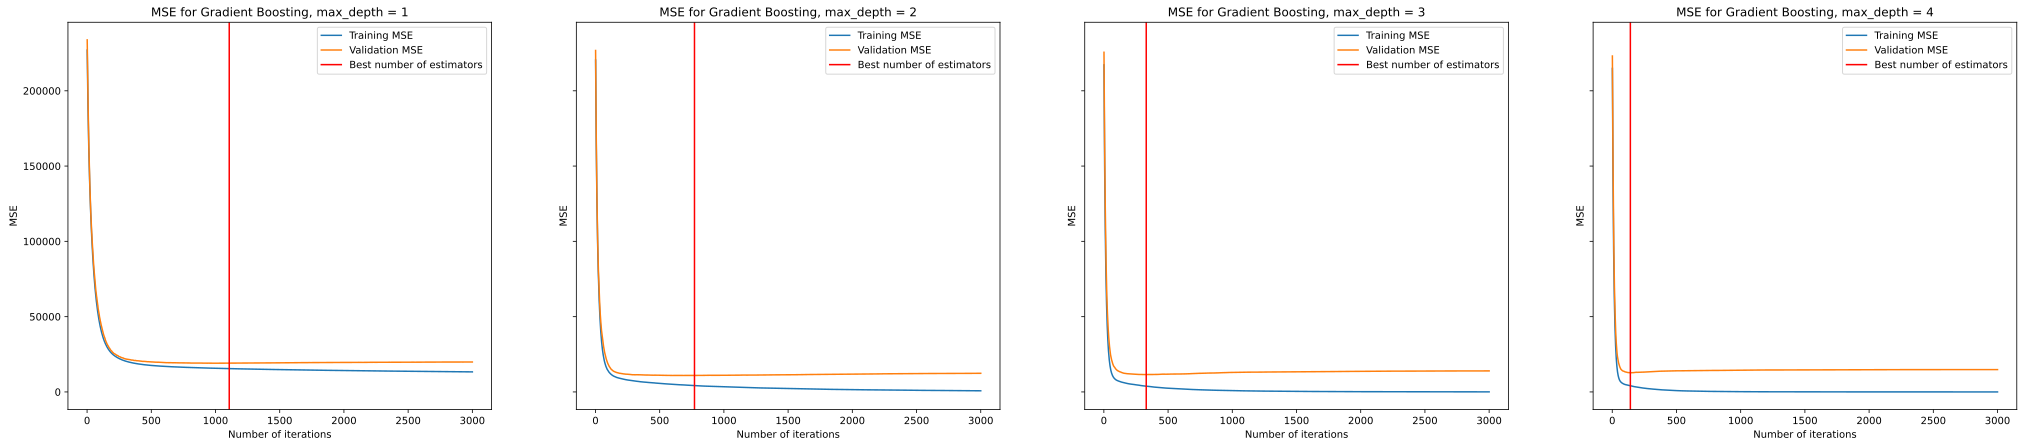

In [18]:
gradient_boost_results = helpers.gradient_boost_model(X_train, y_train)

### XGBoost 

For our AC209 method, we decided to implement XGBoost, which was mentioned in class but the implementation details and specifics of it were not covered. XGBoost stands for eXtreme Gradient Boosting and is known for its performance and speed. As the name implies, XGBoost is based on Gradient Boosting. However, it uses regularization methods to control overfitting and also has computational optimizations so that XGBoost runs faster than Gradient Boosting. Hence, it often performs well in a variety of prediction scenarios. 

The following function trains 6 XGBoost models, with maximum tree depths from 1-6.  For each value for maximum depth, we choose the best number of estimators using a validation set. This validation set is made at the beginning of the function, and for simplicity and speed we use this single validation set to tune all of the XGBoost models. If we had more time and resources, performing cross validation instead of using a single validation set to tune each of the models would be more robust. The function returns a pandas DataFrame with information on each of the XGBoost models. Each rpw contains the maximum depth, the number of estimators that was optimal, and the means squared error (MSE) and R^2 for each model on both the training set and on validation (estimated through cross validation).

The function also produces 6 plots, one for each maximum depth. Each plot shows the training and validation MSE for that maximum depth model as the number of iterations increases. The number of iterations that produces the best training and validation MSE is marked in red.

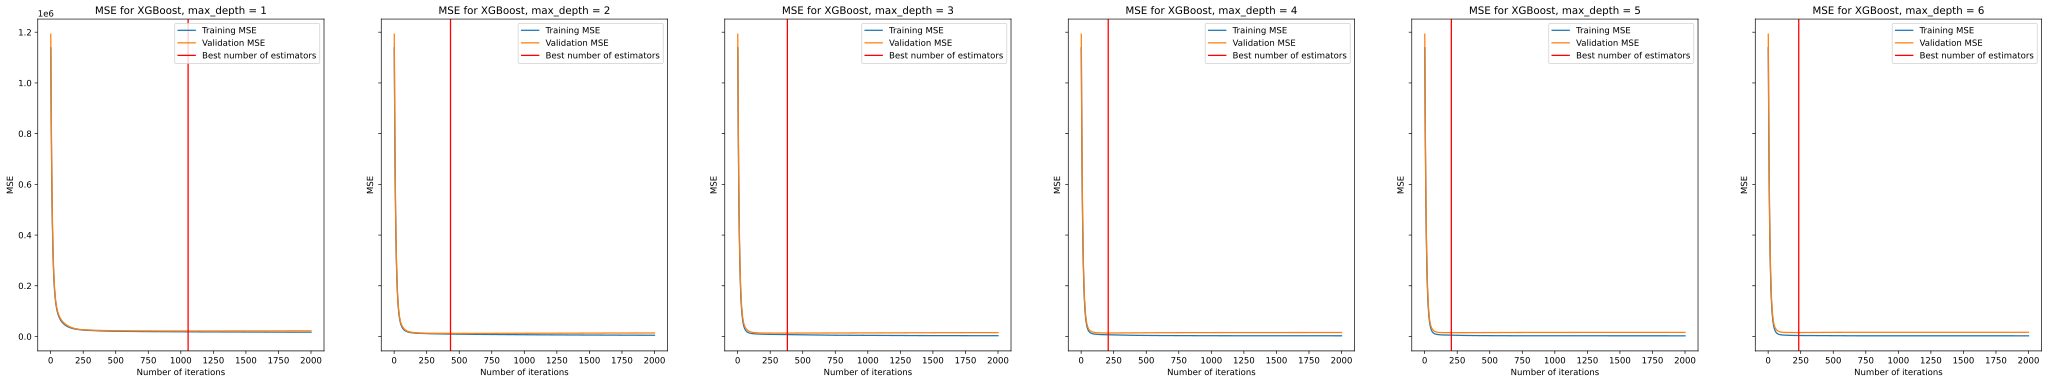

In [19]:
xg_boost_results = helpers.xg_boost_model(X_train, y_train)

### Random Forest and Bagging

The following function creates and tests random forest models while varying hyperparameters in order to determine the best combination for us to use. The hyperparameters that we are changing are `n_trees`, the number of trees in the ensemble, and `max_features`, the number of features randomly selected for the model to use at each split. The function tests all given combinations of `n_trees` and `max_features` through cross-validation and saves train MSE, validation MSE, train r2, and validation r2 to a dataframe for easy viewing. 

The function also creates and tests a bagging model while varying the number of trees in the ensemble in order to determine the best-sized ensemble. While this is technically the same as setting `max_features` to 6 in the random forest model, we thought it would be best to test bagging explicitly. Just like with the random forest function, this function creates models with various values for `n_trees`, scores them through cross-validation, and saves train MSE, validation MSE, train r2, and validation r2 to a DataFrame for easy viewing. 

To compare the results of the various random forest and bagging models we plot them below. In the plot, we have validation MSE versus the number of trees and each line in the plot corresponds to a particular value of `max_features`. The bagging model is also plotted below but since `max_features` is not a hyperparameter for bagging, there is only one curve for bagging while there are 5 different curves for random forest models, one for each value of `max_features`.

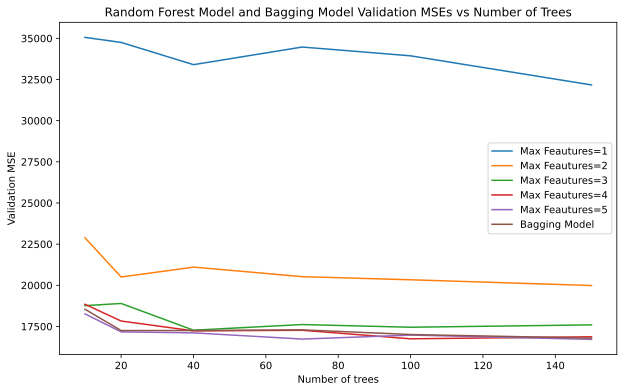

In [20]:
random_forest_results, bagging_results = helpers.random_forest_and_bagging_model(X_train, y_train)

### Final Results - IN PROGRESS DO NOT USE

We combine the results from our bagged and boosted models, along with our random forest to identify the model with the lowest MSE.  We chose to use MSE as our final criterion rather than $R^2$ as each of the models may utilize a different number of features (since we are comparing gradient boosting to XGboosting to random forests) and $R^2$ increases with the number of predictors, usually, since more predictors describe more variance in the data. 

The results below show us that a gradient boosted tree of depth 4 with 141 estimators performs the best out of all the models, followed by 2 XGboost models and a random forest of size 40 with 5 max features. 

In [21]:
combined_df = pd.concat([random_forest_results, bagging_results, xg_boost_results, pd.DataFrame(gradient_boost_results)], ignore_index=True)

combined_df.sort_values(by='val_mse', ascending=True).head()

,name,size,max_features,train_mse,val_mse,train_r2,val_r2,max_depth
45,gradient_boosting,141,NaN,1943.982,15982.658,0.992,0.930,4.0
40,xg_boost,205,NaN,754.589,15985.473,0.997,0.930,5.0
39,xg_boost,208,NaN,1760.742,16064.777,0.993,0.929,4.0
37,xg_boost,433,NaN,4615.844,16580.777,0.980,0.927,2.0
44,gradient_boosting,330,NaN,1594.713,16623.306,0.993,0.927,3.0


The best result is a random forest model with 150 trees and max features set to 6. This is interesting because it is essentially a bagging model since there is no randomness in the subset of predictors used at each split. The trees simply use all of the predictors at each split. For the sake of having a more flexible model moving forward, we will stick with calling this a random forest model even though it is technically the same as a bagging model.

Now that we have our best model selected, we are going to use the function below to test different values for the maximum depth of the trees to determine if that should be a stopping condition. Given more time, we would have included this in the random_forest_model function where we test every combination of hyperparameters, but we have decided not to here because it would take a long time to run. 

In [22]:
# # run test_depths
# depths_test = helpers.test_depths(X_train, y_train, best_n_esimators, best_max_features) 

# # plot the results of test_depths
# sns.lineplot(x='depth', y='val_mse', data=depths_test).set(xlabel='Max Depth', 
#                                                         ylabel='Validation MSE', 
#                                                         title='Validation MSE vs Max Depth for Random Forest Model')

As we can see, once the model is allowed to reach a certain depth, max_depth has no significant impact on the performance of the model. This is the result that we expected because as discussed in class, in order for a random forest model to be accurate, the individual trees that comprise the ensemble must have low bias and this is achieved by having very deep trees. These individual trees will have low bias but extremely high variance. When we put them together to form the random forest, however, the ensemble reduced the variance while maintaining low bias. Because of this result, we will not specify a maximum depth for the trees in the random forest. 

Now, we will create and test our final model on the test data. The final model is a random forest with 150 trees and max_depth set to 6. 

## Improvement and Future Work 

There were a number of points of improvement for this project, which, given the time, we would have implemented. 

### Imputation 
The impuation equations we utilized for the luminosity apply to single, main sequence star systems.  Luckily, this was the majority of our dataset, though we did not have the time to take binary, ternary, non-main sequence stars into account.  That is, we imputed *as if* the formulas accurately applied to them.  This could be leading to decreased performance and accuracy with imputation. 

Similarly, the imputation for mass and radius was used based on empirical data and modeling made by another team that was published in a textbook used to teach at Harvard.  Given more time, we could have trained, tuned, and tested our own regression for the imputation of the stellar mass and radius rather than utilizing another team's.  

### Models and Tuning 
Given more time and resources, we may have considered testing a wider variety of models before choosing a baseline, along with more in-depth hyperparameter tuning.  For example, we may have considered tuning the random forest's depth at the same time as its `max_features` and `n_estimators`, along with more consideration as to which stopping conditions to choose.  Because this tuning was computationally expensive, and the code already took quite long to run, we ended up being unable to do so.  In the future, further tuning may improve the predictive power of our model. 